In [1]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from skforecast.ForecasterAutoreg import ForecasterAutoreg
# from skforecast.model_selection import grid_search_forecaster
# from skforecast.model_selection import time_series_spliter
# from skforecast.model_selection import cv_forecaster

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
from skforecast.ForecasterCustom import ForecasterCustom
#from skforecast.ForecasterAutoreg import ForecasterAutoreg

## ForecasterAutoreg

In [70]:
################################################################################
#                               skforecast                                     #
#                                                                              #
# This work by Joaquín Amat Rodrigo is licensed under a Creative Commons       #
# Attribution 4.0 International License.                                       #
################################################################################
# coding=utf-8

import typing
from typing import Union, Dict
import warnings
import logging
import numpy as np
import pandas as pd
import sklearn
import tqdm


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


logging.basicConfig(
    format = '%(asctime)-5s %(name)-10s %(levelname)-5s %(message)s', 
    level  = logging.INFO,
)


################################################################################
#                             ForecasterAutoreg                                #
################################################################################

class ForecasterAutoreg():
    '''
    This class turns a scikit-learn regressor into a recursive autoregressive
    (multi-step) forecaster.
    
    Parameters
    ----------
    regressor : scikit-learn regressor
        An instance of a scikit-learn regressor.
        
    lags : int, list, 1D np.array, range
        Lags used as predictors. Index starts at 1, so lag 1 is equal to t-1.
            `int`: include lags from 1 to `lags` (included).
            `list` or `np.array`: include only lags present in `lags`.

    
    Attributes
    ----------
    regressor : scikit-learn regressor
        An instance of a scikit-learn regressor.
        
    lags : 1D np.array
        Lags used as predictors.
        
    max_lag : int
        Maximum value of lag included in lags.
        
    last_window : 1D np.ndarray
        Last time window the forecaster has seen when trained. It stores the
        values needed to calculate the lags used to predict the next `step`
        after the training data.
        
    included_exog : bool
        If the forecaster has been trained using exogenous variable/s.
        
    exog_type : type
        Type used for the exogenous variable/s.
            
    exog_shape : tuple
        Shape of exog used in training.
        
    in_sample_residuals: np.ndarray
        Residuals of the model when predicting training data. Only stored up to
        1000 values.
        
    out_sample_residuals: np.ndarray
        Residuals of the model when predicting non training data. Only stored
        up to 1000 values.
     
    '''
    
    def __init__(self, regressor, lags: Union[int, np.ndarray, list]) -> None:
        
        self.regressor     = regressor
        self.last_window   = None
        self.included_exog = False
        self.exog_type     = False
        self.exog_shape    = None
        self.in_sample_residuals  = None
        self.out_sample_residuals = None
        
        if isinstance(lags, int) and lags < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, (list, range, np.ndarray)) and min(lags) < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, int):
            self.lags = np.arange(lags) + 1
        elif isinstance(lags, (list, range)):
            self.lags = np.array(lags)
        elif isinstance(lags, np.ndarray):
            self.lags = lags
        else:
            raise Exception(
                f"`lags` argument must be `int`, `1D np.ndarray`, `range` or `list`. "
                f"Got {type(lags)}"
            )
            
        self.max_lag  = max(self.lags)
                
        
    def __repr__(self) -> str:
        '''
        Information displayed when a ForecasterAutoreg object is printed.
        '''

        info =    "=======================" \
                + "ForecasterAutoreg" \
                + "=======================" \
                + "\n" \
                + "Regressor: " + str(self.regressor) \
                + "\n" \
                + "Lags: " + str(self.lags) \
                + "\n" \
                + "Exogenous variable: " + str(self.included_exog) \
                + "\n" \
                + "Parameters: " + str(self.regressor.get_params())

        return info

    
    
    def create_lags(self, y: Union[np.ndarray, pd.Series]) -> Dict[np.ndarray, np.ndarray]:
        '''       
        Transforms a time series into a 2D array and a 1D array where each value
        of `y` is associated with the lags that precede it.
        
        Notice that the returned matrix X_data, contains the lag 1 in the
        first column, the lag 2 in the second column and so on.
        
        Parameters
        ----------        
        y : 1D np.ndarray, pd.Series
            Training time series.

        Returns 
        -------
        X_data : 2D np.ndarray, shape (samples, len(self.lags))
            2D array with the lag values (predictors).
        
        y_data : 1D np.ndarray, shape (nº observaciones - max(seld.lags),)
            Values of the time series related to each row of `X_data`.
            
        '''
        
        self._check_y(y=y)
        y = self._preproces_y(y=y)        
        
        if self.max_lag > len(y):
            raise Exception(
                f"Maximum lag can't be higher than `y` length. "
                f"Got maximum lag={self.max_lag} and `y` length={len(y)}."
            )
            
        n_splits = len(y) - self.max_lag
        X_data  = np.full(shape=(n_splits, self.max_lag), fill_value=np.nan, dtype=float)
        y_data  = np.full(shape=(n_splits, 1), fill_value=np.nan, dtype= float)

        for i in range(n_splits):
            train_index = np.arange(i, self.max_lag + i)
            test_index  = [self.max_lag + i]

            X_data[i, :] = y[train_index]
            y_data[i]    = y[test_index]
            
        X_data = X_data[:, -self.lags]
        y_data = y_data.ravel()
            
        return X_data, y_data

        
    def fit(self, y: Union[np.ndarray, pd.Series], exog: Union[np.ndarray, pd.Series]=None) -> None:
        '''
        Training ForecasterAutoreg
        
        Parameters
        ----------        
        y : 1D np.ndarray, pd.Series
            Training time series.
            
        exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].


        Returns 
        -------
        self : ForecasterAutoreg
            Trained ForecasterAutoreg
        
        '''
        
        # Reset values in case the forecaster has already been fitted before.
        self.included_exog = False
        self.exog_type     = None
        self.exog_shape    = None
        
        self._check_y(y=y)
        y = self._preproces_y(y=y)
        
        if exog is not None:
            self._check_exog(exog=exog)
            self.exog_type = type(exog)
            exog = self._preproces_exog(exog=exog)
            self.included_exog = True
            self.exog_shape = exog.shape
            
            if exog.shape[0] != len(y):
                raise Exception(
                    f"`exog` must have same number of samples as `y`"
                )
                
        
        X_train, y_train = self.create_lags(y=y)
        
        if exog is not None:
            self.regressor.fit(
                # The first `self.max_lag` positions have to be removed from exog
                # since they are not in X_train.
                X = np.column_stack((X_train, exog[self.max_lag:,])),
                y = y_train
            )
            
            residuals = y_train - self.regressor.predict(
                                        np.column_stack((X_train, exog[self.max_lag:,]))
                                  )
                        
        else:
            self.regressor.fit(X=X_train, y=y_train)            
            residuals = y_train - self.regressor.predict(X_train)
            
        if len(residuals) > 1000:
            # Only up to 1000 residuals are stored
            residuals = np.random.choice(a=residuals, size=1000, replace=False)                                              
        self.in_sample_residuals = residuals
        
        # The last time window of training data is stored so that lags needed as
        # predictors in the first iteration of `predict()` can be calculated.
        self.last_window = y_train[-self.max_lag:].copy()
        
            
    def predict(self, steps: int, last_window: Union[np.ndarray, pd.Series]=None,
                exog: np.ndarray=None):
        '''
        Iterative process in which, each prediction, is used as a predictor
        for the next step.
        
        Parameters
        ----------
               
        steps : int
            Number of future steps predicted.
            
        last_window : 1D np.ndarray, pd.Series, shape (, max_lag), default `None`
            Values of the series used to create the predictors (lags) need in the 
            first iteration of predictiont (t + 1).
    
            If `last_window = None`, the values stored in` self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.
            
        exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s.

        Returns 
        -------
        predictions : 1D np.array, shape (steps,)
            Values predicted.
            
        '''
        
        if steps < 1:
            raise Exception(
                f"`steps` must be integer greater than 0. Got {steps}."
            )
        
        if exog is None and self.included_exog:
            raise Exception(
                f"Forecaster trained with exogenous variable/s. "
                f"Same variable/s must be provided in `predict()`."
            )
            
        if exog is not None and not self.included_exog:
            raise Exception(
                f"Forecaster trained without exogenous variable/s. "
                f"`exog` must be `None` in `predict()`."
            )
        
        if exog is not None:
            self._check_exog(
                exog=exog, ref_type = self.exog_type, ref_shape=self.exog_shape
            )
            exog = self._preproces_exog(exog=exog)
            if exog.shape[0] < steps:
                raise Exception(
                    f"`exog` must have at least as many values as `steps` predicted."
                )
     
        if last_window is not None:
            self._check_last_window(last_window=last_window)
            last_window = self._preproces_last_window(last_window=last_window)
            if last_window.shape[0] < self.max_lag:
                raise Exception(
                    f"`last_window` must have as many values as as needed to "
                    f"calculate the maximum lag ({self.max_lag})."
                )
        else:
            last_window = self.last_window.copy()
            
        predictions = np.full(shape=steps, fill_value=np.nan)

        for i in range(steps):
            X = last_window[-self.lags].reshape(1, -1)
            if exog is None:
                prediction = self.regressor.predict(X=X)
            else:
                prediction = self.regressor.predict(
                                X = np.column_stack((X, exog[i,].reshape(1, -1)))
                             )
            predictions[i] = prediction.ravel()[0]

            # Update `last_window` values. The first position is discarded and 
            # the new prediction is added at the end.
            last_window = np.append(last_window[1:], prediction)

        return predictions
    
    
    def _estimate_boot_interval(self, steps: int,
                                last_window: Union[np.ndarray, pd.Series]=None,
                                exog: np.ndarray=None, interval: list=[5, 95],
                                n_boot: int=500, in_sample_residuals: bool=True):
        '''
        Iterative process in which, each prediction, is used as a predictor
        for the next step and bootstrapping is used to estimate prediction
        intervals. This method only returns prediction intervals.
        See predict_intervals() to calculate both, predictions and intervals.
        
        Parameters
        ----------
               
        steps : int
            Number of future steps predicted.
            
        last_window : 1D np.ndarray, pd.Series, shape (, max_lag), default `None`
            Values of the series used to create the predictors (lags) need in the 
            first iteration of predictiont (t + 1).
    
            If `last_window = None`, the values stored in` self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.
            
        exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s.
            
        n_boot: int, default `100`
            Number of bootstrapping iterations used to estimate prediction
            intervals.
            
        interval: list, default `[5, 100]`
            Confidence of the prediction interval estimated. Sequence of percentiles
            to compute, which must be between 0 and 100 inclusive.
            
        in_sample_residuals: bool, default `True`
            If `True`, residuals from the training data are used as proxy of
            prediction error to create prediction intervals. If `False`, out of
            sample residuals are used. In the latter case, the user shoud have
            calculated and stored the residuals within the forecaster (see
            `set_out_sample_residuals()`).
            

        Returns 
        -------
        predicction_interval : np.array, shape (steps, 2)
            Interval estimated for each prediction by bootstrapping.

        Notes
        -----
        More information about prediction intervals in forecasting:
        https://otexts.com/fpp2/prediction-intervals.html
        Forecasting: Principles and Practice (2nd ed) Rob J Hyndman and
        George Athanasopoulos.
            
        '''
        
        if steps < 1:
            raise Exception(
                f"`steps` must be integer greater than 0. Got {steps}."
            )
            
        if not in_sample_residuals and self.out_sample_residuals is None:
            raise Exception(
                ('out_sample_residuals is empty. In order to estimate prediction '
                'intervals using out of sample residuals, the user shoud have '
                'calculated and stored the residuals within the forecaster (see'
                '`set_out_sample_residuals()`.')
            )

        if exog is None and self.included_exog:
            raise Exception(
                f"Forecaster trained with exogenous variable/s. "
                f"Same variable/s must be provided in `predict()`."
            )

        if exog is not None and not self.included_exog:
            raise Exception(
                f"Forecaster trained without exogenous variable/s. "
                f"`exog` must be `None` in `predict()`."
            )

        if exog is not None:
            self._check_exog(
                exog=exog, ref_type = self.exog_type, ref_shape=self.exog_shape
            )
            exog = self._preproces_exog(exog=exog)
            if exog.shape[0] < steps:
                raise Exception(
                    f"`exog` must have at least as many values as `steps` predicted."
                )

        if last_window is not None:
            self._check_last_window(last_window=last_window)
            last_window = self._preproces_last_window(last_window=last_window)
            if last_window.shape[0] < self.max_lag:
                raise Exception(
                    f"`last_window` must have as many values as as needed to "
                    f"calculate the maximum lag ({self.max_lag})."
                )
        else:
            last_window = self.last_window.copy()

        boot_predictions = np.full(
                                shape      = (steps, n_boot),
                                fill_value = np.nan,
                                dtype      = float
                           )

        for i in range(n_boot):

            # In each bootstraping iteration the initial last_window and exog 
            # need to be restored.
            last_window_boot = last_window.copy()
            if exog is not None:
                exog_boot = exog.copy()
            else:
                exog_boot = None
                
            if in_sample_residuals:
                residuals = self.in_sample_residuals
            else:
                residuals = self.out_sample_residuals

            sample_residuals = np.random.choice(
                                    a       = residuals,
                                    size    = steps,
                                    replace = True
                               )

            for step in range(steps):  
                prediction = self.predict(
                                steps       = 1,
                                last_window = last_window_boot,
                                exog        = exog_boot
                             )
                
                prediction_with_residual  = prediction + sample_residuals[step]
                boot_predictions[step, i] = prediction_with_residual

                last_window_boot = np.append(
                                    last_window_boot[1:],
                                    prediction_with_residual
                                   )
                
                if exog is not None:
                    exog_boot = exog_boot[1:]
                            
        prediction_interval = np.percentile(boot_predictions, q=interval, axis=1)
        prediction_interval = prediction_interval.transpose()
        
        return prediction_interval
    
        
    def predict_interval(self, steps: int, last_window: Union[np.ndarray, pd.Series]=None,
                         exog: np.ndarray=None, interval: list=[5, 95],
                         n_boot: int=500, in_sample_residuals: bool=True):
        '''
        Iterative process in which, each prediction, is used as a predictor
        for the next step and bootstrapping is used to estimate prediction
        intervals. Both, predictions and intervals, are returned.
        
        Parameters
        ----------
               
        steps : int
            Number of future steps predicted.
            
        last_window : 1D np.ndarray, pd.Series, shape (, max_lag), default `None`
            Values of the series used to create the predictors (lags) need in the 
            first iteration of predictiont (t + 1).
    
            If `last_window = None`, the values stored in` self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.
            
        exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s.
            
        interval: list, default `[5, 100]`
            Confidence of the prediction interval estimated. Sequence of percentiles
            to compute, which must be between 0 and 100 inclusive.
            
        n_boot: int, default `500`
            Number of bootstrapping iterations used to estimate prediction
            intervals.
            
        in_sample_residuals: bool, default `True`
            If `True`, residuals from the training data are used as proxy of
            prediction error to create prediction intervals. If `False`, out of
            sample residuals are used. In the latter case, the user shoud have
            calculated and stored the residuals within the forecaster (see
            `set_out_sample_residuals()`).

        Returns 
        -------
        predictions : np.array, shape (steps, 3)
            Values predicted by the forecaster and their estimated interval.
            Column 0 = predictions
            Column 1 = lower bound interval
            Column 2 = upper bound interval

        Notes
        -----
        More information about prediction intervals in forecasting:
        https://otexts.com/fpp2/prediction-intervals.html
        Forecasting: Principles and Practice (2nd ed) Rob J Hyndman and
        George Athanasopoulos.
            
        '''
        
        if steps < 1:
            raise Exception(
                f"`steps` must be integer greater than 0. Got {steps}."
            )
            
        if not in_sample_residuals and self.out_sample_residuals is None:
            raise Exception(
                ('out_sample_residuals is empty. In order to estimate prediction '
                'intervals using out of sample residuals, the user shoud have '
                'calculated and stored the residuals within the forecaster (see'
                '`set_out_sample_residuals()`.')
            )
        
        if exog is None and self.included_exog:
            raise Exception(
                f"Forecaster trained with exogenous variable/s. "
                f"Same variable/s must be provided in `predict()`."
            )
            
        if exog is not None and not self.included_exog:
            raise Exception(
                f"Forecaster trained without exogenous variable/s. "
                f"`exog` must be `None` in `predict()`."
            )
        
        if exog is not None:
            self._check_exog(
                exog=exog, ref_type = self.exog_type, ref_shape=self.exog_shape
            )
            exog = self._preproces_exog(exog=exog)
            if exog.shape[0] < steps:
                raise Exception(
                    f"`exog` must have as many values as `steps` predicted."
                )
     
        if last_window is not None:
            self._check_last_window(last_window=last_window)
            last_window = self._preproces_last_window(last_window=last_window)
            if last_window.shape[0] < self.max_lag:
                raise Exception(
                    f"`last_window` must have as many values as as needed to "
                    f"calculate the maximum lag ({self.max_lag})."
                )
        else:
            last_window = self.last_window.copy()
        
        # Since during predict() `last_window` and `exog` are modified, the
        # originals are stored to be used later
        last_window_original = last_window.copy()
        if exog is not None:
            exog_original = exog.copy()
        else:
            exog_original = exog
            
        predictions = self.predict(
                            steps       = steps,
                            last_window = last_window,
                            exog        = exog
                      )

        predictions_interval = self._estimate_boot_interval(
                                    steps       = steps,
                                    last_window = last_window_original,
                                    exog        = exog_original,
                                    interval    = interval,
                                    n_boot      = n_boot,
                                    in_sample_residuals = in_sample_residuals
                                )
        
        predictions = np.column_stack((predictions, predictions_interval))

        return predictions

    
    def _check_y(self, y: Union[np.ndarray, pd.Series]) -> None:
        '''
        Raise Exception if `y` is not 1D `np.ndarray` or `pd.Series`.
        
        Parameters
        ----------        
        y : np.ndarray, pd.Series
            Time series values

        '''
        
        if not isinstance(y, (np.ndarray, pd.Series)):
            raise Exception('`y` must be `1D np.ndarray` or `pd.Series`.')
        elif isinstance(y, np.ndarray) and y.ndim != 1:
            raise Exception(
                f"`y` must be `1D np.ndarray` o `pd.Series`, "
                f"got `np.ndarray` with {y.ndim} dimensions."
            )
            
        return
    
    
    def _check_last_window(self, last_window: Union[np.ndarray, pd.Series]) -> None:
        '''
        Raise Exception if `last_window` is not 1D `np.ndarray` or `pd.Series`.
        
        Parameters
        ----------        
        last_window : np.ndarray, pd.Series
            Time series values

        '''
        
        if not isinstance(last_window, (np.ndarray, pd.Series)):
            raise Exception('`last_window` must be `1D np.ndarray` or `pd.Series`.')
        elif isinstance(last_window, np.ndarray) and last_window.ndim != 1:
            raise Exception(
                f"`last_window` must be `1D np.ndarray` o `pd.Series`, "
                f"got `np.ndarray` with {last_window.ndim} dimensions."
            )
            
        return
        
        
    def _check_exog(self, exog: Union[np.ndarray, pd.Series], 
                    ref_type: type=None, ref_shape: tuple=None) -> None:
        '''
        Raise Exception if `exog` is not `np.ndarray` or `pd.Series`.
        If `ref_shape` is provided, raise Exception if `ref_shape[1]` do not match
        `exog.shape[1]` (number of columns).
        
        Parameters
        ----------        
        exog : np.ndarray, pd.Series
            Time series values

        '''
            
        if not isinstance(exog, (np.ndarray, pd.Series)):
            raise Exception('`exog` must be `np.ndarray` or `pd.Series`.')
            
        if isinstance(exog, np.ndarray) and exog.ndim > 2:
            raise Exception(
                    f" If `exog` is `np.ndarray`, maximum allowed dim=2. "
                    f"Got {exog.ndim}."
                )
            
        if ref_type is not None:
            
            if ref_type == pd.Series:
                if isinstance(exog, pd.Series):
                    return
                elif isinstance(exog, np.ndarray) and exog.ndim == 1:
                    return
                elif isinstance(exog, np.ndarray) and exog.shape[1] == 1:
                    return
                else:
                    raise Exception(
                        f"`exog` must be: `pd.Series`, `np.ndarray` with 1 dimension"
                        f"or `np.ndarray` with 1 column in the second dimension. "
                        f"Got `np.ndarray` with {exog.shape[1]} columns."
                    )
                    
            if ref_type == np.ndarray:
                if exog.ndim == 1 and ref_shape[1] == 1:
                    return
                elif exog.ndim == 1 and ref_shape[1] > 1:
                    raise Exception(
                        f"`exog` must have {ref_shape[1]} columns. "
                        f"Got `np.ndarray` with 1 dimension or `pd.Series`."
                    )
                elif ref_shape[1] != exog.shape[1]:
                    raise Exception(
                        f"`exog` must have {ref_shape[1]} columns. "
                        f"Got `np.ndarray` with {exog.shape[1]} columns."
                    )     
        return
    
        
    def _preproces_y(self, y) -> np.ndarray:
        
        '''
        Transforms `y` to 1D `np.ndarray` if it is `pd.Series`.
        
        Parameters
        ----------        
        y :1D np.ndarray, pd.Series
            Time series values

        Returns 
        -------
        y: 1D np.ndarray, shape(samples,)
        '''
        
        if isinstance(y, pd.Series):
            return y.to_numpy()
        else:
            return y
        
    def _preproces_last_window(self, last_window) -> np.ndarray:
        
        '''
        Transforms `last_window` to 1D `np.ndarray` if it is `pd.Series`.
        
        Parameters
        ----------        
        last_window :1D np.ndarray, pd.Series
            Time series values

        Returns 
        -------
        last_window: 1D np.ndarray, shape(samples,)
        '''
        
        if isinstance(last_window, pd.Series):
            return last_window.to_numpy()
        else:
            return last_window
        
        
    def _preproces_exog(self, exog) -> np.ndarray:
        
        '''
        Transforms `exog` to `np.ndarray` if it is `pd.Series`.
        If 1D `np.ndarray` reshape it to (n_samples, 1)
        
        Parameters
        ----------        
        exog : np.ndarray, pd.Series
            Time series values

        Returns 
        -------
        exog: np.ndarray, shape(samples,)
        '''
        
        if isinstance(exog, pd.Series):
            exog = exog.to_numpy().reshape(-1, 1)
        elif isinstance(exog, np.ndarray) and exog.ndim == 1:
            exog = exog.reshape(-1, 1)
            
        return exog
    
    
    def set_params(self, **params: dict) -> None:
        '''
        Set new values to the parameters of the scikit learn model stored in the
        ForecasterAutoreg.
        
        Parameters
        ----------
        params : dict
            Parameters values.

        Returns 
        -------
        self
        
        '''
        
        self.regressor.set_params(**params)
        
        
    def set_lags(self, lags: int) -> None:
        '''      
        Set new value to the attribute `lags`.
        Attribute `max_lag` is also updated.
        
        Parameters
        ----------
        lags : int, list, 1D np.array, range
        Lags used as predictors. Index starts at 1, so lag 1 is equal to t-1.
            `int`: include lags from 1 to `lags`.
            `list` or `np.array`: include only lags present in `lags`.

        Returns 
        -------
        self
        
        '''
        
        if isinstance(lags, int) and lags < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, (list, range, np.ndarray)) and min(lags) < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, int):
            self.lags = np.arange(lags) + 1
        elif isinstance(lags, (list, range)):
            self.lags = np.array(lags)
        elif isinstance(lags, np.ndarray):
            self.lags = lags
        else:
            raise Exception(
                f"`lags` argument must be `int`, `1D np.ndarray`, `range` or `list`. "
                f"Got {type(lags)}"
            )
            
        self.max_lag  = max(self.lags)
        
        
    def set_out_sample_residuals(self, residuals: np.ndarray) -> None:
        '''
        Set new values to the attribute `out_sample_residuals`. Out of sample
        residuals are meant to be calculated using observations that did not
        participate in the training process.
        
        Parameters
        ----------
        params : 1D np.ndarray
            Values of residuals. If len(residuals) > 1000, only a random sample
            of 1000 values are stored.

        Returns 
        -------
        self
        
        '''
        if not isinstance(residuals, np.ndarray):
            raise Exception(
                f"`residuals` argument must be `1D np.ndarray`. Got {type(lags)}"
            )
            
        if len(residuals) > 1000:
            residuals = np.random.choice(a=residuals, size=1000, replace=False)
            
        self.out_sample_residuals = residuals
        

    def get_coef(self) -> np.ndarray:
        '''      
        Return estimated coefficients for the linear regression model stored in
        the forecaster. Only valid when the forecaster has been trained using
        as `regressor: `LinearRegression()`, `Lasso()` or `Ridge()`.
        
        Parameters
        ----------
        self

        Returns 
        -------
        coef : 1D np.ndarray
            Value of the coefficients associated with each predictor (lag).
            Coefficients are aligned so that `coef[i]` is the value associated
            with `self.lags[i]`.
        
        '''
        
        valid_instances = (sklearn.linear_model._base.LinearRegression,
                          sklearn.linear_model._coordinate_descent.Lasso,
                          sklearn.linear_model._ridge.Ridge
                          )
        
        if not isinstance(self.regressor, valid_instances):
            warnings.warn(
                ('Only forecasters with `regressor` `LinearRegression()`, ' +
                 ' `Lasso()` or `Ridge()` have coef.')
            )
            return
        else:
            coef = self.regressor.coef_
            
        return coef

    
    def get_feature_importances(self) -> np.ndarray:
        '''      
        Return impurity-based feature importances of the model stored in the
        forecaster. Only valid when the forecaster has been trained using
        `regressor=GradientBoostingRegressor()` or `regressor=RandomForestRegressor`.

        Parameters
        ----------
        self

        Returns 
        -------
        feature_importances : 1D np.ndarray
        Impurity-based feature importances associated with each predictor (lag).
        Values are aligned so that `feature_importances[i]` is the value
        associated with `self.lags[i]`.
        '''

        if not isinstance(self.regressor,
                        (sklearn.ensemble._forest.RandomForestRegressor,
                        sklearn.ensemble._gb.GradientBoostingRegressor)):
            warnings.warn(
                ('Only forecasters with `regressor=GradientBoostingRegressor()` '
                 'or `regressor=RandomForestRegressor`.')
            )
            return
        else:
            feature_importances = self.regressor.feature_importances_

        return feature_importances

In [4]:
################################################################################
#                        skforecast.model_selection                            #
#                                                                              #
# This work by Joaquín Amat Rodrigo is licensed under a Creative Commons       #
# Attribution 4.0 International License.                                       #
################################################################################
# coding=utf-8

import typing
from typing import Union, Dict
import numpy as np
import pandas as pd
import logging
import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

# from .ForecasterAutoreg import ForecasterAutoreg
# from .ForecasterCustom import ForecasterCustom

logging.basicConfig(
    format = '%(asctime)-5s %(name)-10s %(levelname)-5s %(message)s', 
    level  = logging.INFO,
)

def time_series_spliter(y: Union[np.ndarray, pd.Series],
                        initial_train_size: int, steps: int,
                        allow_incomplete_fold: bool=True) -> Dict[np.ndarray, np.ndarray]:
    '''
    
    Split indices of a time series into multiple train-test pairs. The order of
    is maintained and the training set increases in each iteration.
    
    Parameters
    ----------        
    y : 1D np.ndarray, pd.Series
        Training time series values. 
    
    initial_train_size: int 
        Number of samples in the initial train split.
        
    steps : int
        Number of steps to predict.
        
    allow_incomplete_fold : bool, default `True`
        The last test set is allowed to be incomplete if it does not reach `steps`
        observations. Otherwise, the latest observations are discarded.

    Yields
    ------
    train : 1D np.ndarray
        Training indices.
        
    test : 1D np.ndarray
        Test indices.
        
    '''
    
    if not isinstance(y, (np.ndarray, pd.Series)):

        raise Exception('`y` must be `1D np.ndarray` o `pd.Series`.')

    elif isinstance(y, np.ndarray) and y.ndim != 1:

        raise Exception(
            f"`y` must be `1D np.ndarray` o `pd.Series`, "
            f"got `np.ndarray` with {y.ndim} dimensions."
        )
        
    if isinstance(y, pd.Series):
        y = y.to_numpy().copy()
    
  
    folds     = (len(y) - initial_train_size) // steps  + 1
    remainder = (len(y) - initial_train_size) % steps    
    
    for i in range(folds):
          
        if i < folds - 1:
            train_end     = initial_train_size + i * steps    
            train_indices = range(train_end)
            test_indices  = range(train_end, train_end + steps)
            
        else:
            if remainder != 0 and allow_incomplete_fold:
                train_end     = initial_train_size + i * steps  
                train_indices = range(train_end)
                test_indices  = range(train_end, train_end + remainder)
            else:
                break
        
        yield train_indices, test_indices
        

def cv_forecaster(forecaster, y: Union[np.ndarray, pd.Series],
                  initial_train_size: int, steps: int,
                  metric: str, exog: Union[np.ndarray, pd.Series]=None,
                  allow_incomplete_fold: bool=True):
    '''
    Cross-validation of `ForecasterAutoreg` or `ForecasterCustom` object.
    The order of is maintained and the training set increases in each iteration.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg, ForecasterCustom
        `ForecasterAutoreg` or `ForecasterCustom` object.
        
    y : 1D np.ndarray, pd.Series
        Training time series values. 
    
    initial_train_size: int 
        Number of samples in the initial train split.
        
    steps : int
        Number of steps to predict.
        
    metric : {'neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'}
        Metric used to quantify the goodness of fit of the model.
        
    exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].
            
    allow_incomplete_fold : bool, default `True`
        The last test set is allowed to be incomplete if it does not reach `steps`
        observations. Otherwise, the latest observations are discarded.

    Returns 
    -------
    cv_results: 1D np.ndarray
        Value of the metric for each partition.

    '''
    
    forecaster._check_y(y=y)
    y = forecaster._preproces_y(y=y)
    
    if exog is not None:
        forecaster._check_exog(exog=exog)
        exog = forecaster._preproces_exog(exog=exog)
    
    cv_results = []
    
    metrics = {
        'neg_mean_squared_error': mean_squared_error,
        'neg_mean_absolute_error': mean_absolute_error,
        'neg_mean_absolute_percentage_error': mean_absolute_percentage_error
    }
    
    metric = metrics[metric]
    
    splits = time_series_spliter(
                y                     = y,
                initial_train_size    = initial_train_size,
                steps                 = steps,
                allow_incomplete_fold = allow_incomplete_fold
             )
    
    for train_index, test_index in splits:
        
        if exog is None:
            forecaster.fit(y=y[train_index])      
            pred = forecaster.predict(steps=len(test_index))
            
        else:
            
            forecaster.fit(y=y[train_index], exog=exog[train_index])      
            pred = forecaster.predict(steps=len(test_index), exog=exog[test_index])
               
        metric_value = metric(
                            y_true = y[test_index],
                            y_pred = pred
                       )
        
        cv_results.append(metric_value)
                          
    return np.array(cv_results)


def backtesting_forecaster(forecaster, y: Union[np.ndarray, pd.Series],
                           initial_train_size: int, steps: int,
                           metric: str, exog: Union[np.ndarray, pd.Series]=None):
    '''
    Backtesting (validation) of `ForecasterAutoreg` or `ForecasterCustom` object.
    The model is trained only once using the `initial_train_size` first observations.
    In each iteration, a number of `steps` predictions are evaluated.
    
    This evaluation is much faster than `cv_forecaster()` since the model is
    trained only once.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg, ForecasterCustom
        `ForecasterAutoreg` or `ForecasterCustom` object.
        
    y : 1D np.ndarray, pd.Series
        Training time series values. 
    
    initial_train_size: int 
        Number of samples in the initial train split.
        
    steps : int
        Number of steps to predict.
        
    metric : {'neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'}
        Metric used to quantify the goodness of fit of the model.
        
    exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].

    Returns 
    -------
    backtest_predictions: 1D np.ndarray
        Value of predictions.
        
    metric_value: np.ndarray shape (1,)
        Value of the metric.

    '''
    
    forecaster._check_y(y=y)
    y = forecaster._preproces_y(y=y)
    
    if exog is not None:
        forecaster._check_exog(exog=exog)
        exog = forecaster._preproces_exog(exog=exog)
    
    backtest_predictions = []
    
    metrics = {
        'neg_mean_squared_error': mean_squared_error,
        'neg_mean_absolute_error': mean_absolute_error,
        'neg_mean_absolute_percentage_error': mean_absolute_percentage_error
    }
    
    metric = metrics[metric]
        
    if exog is None:
        forecaster.fit(y=y[:initial_train_size])      
    else:
        forecaster.fit(y=y[:initial_train_size], exog=exog[:initial_train_size])     
    
    
    folds     = (len(y) - initial_train_size) // steps + 1
    remainder = (len(y) - initial_train_size) % steps
    window_size = len(forecaster.last_window)
    
    for i in range(folds):
        
        last_window_end   = initial_train_size + i * steps
        last_window_start = (initial_train_size + i * steps) - window_size 
        last_window       = y[last_window_start:last_window_end]
                
        if i < folds - 1:
            if exog is None:
                pred = forecaster.predict(
                            steps       = steps,
                            last_window = last_window
                        )
            else:
                pred = forecaster.predict(
                            steps       = steps,
                            last_window = last_window,
                            exog        = exog[last_window_end:last_window_end + steps]
                        )
        elif remainder != 0:
            steps = remainder 
            if exog is None:
                pred = forecaster.predict(
                            steps       = steps,
                            last_window = last_window
                        )
            else:
                pred = forecaster.predict(
                            steps       = steps,
                            last_window = last_window,
                            exog        = exog[last_window_end:last_window_end + steps]
                        )
        else:
            continue
        
        backtest_predictions.append(pred)
    
    backtest_predictions = np.concatenate(backtest_predictions)
    metric_value = metric(
                        y_true = y[initial_train_size:],
                        y_pred = backtest_predictions
                   )

    return np.array([metric_value]), backtest_predictions



def grid_search_forecaster(forecaster, y: Union[np.ndarray, pd.Series],
                           param_grid: dict, initial_train_size: int, steps: int,
                           metric: str, exog: Union[np.ndarray, pd.Series]=None,
                           lags_grid: list=None, method: str='cv',
                           allow_incomplete_fold: bool=True, return_best: bool=True):
    '''
    Exhaustive search over specified parameter values for a Forecaster object.
    Validation is done using time series cross-validation or backtesting.
    
    Parameters
    ----------
    
    forecaster : ForecasterAutoreg, ForecasterCustom
        ForecasterAutoreg or ForecasterCustom object.
        
    y : 1D np.ndarray, pd.Series
        Training time series values. 
        
    param_grid : dict
        Dictionary with parameters names (`str`) as keys and lists of parameter
        settings to try as values.
    
    initial_train_size: int 
        Number of samples in the initial train split.
        
    steps : int
        Number of steps to predict.
        
    metric : {'neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'}
        Metric used to quantify the goodness of fit of the model.
        
    exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].
           
    lags_grid : list of int, lists, np.narray or range. 
        Lists of `lags` to try. Only used if forecaster is an instance of 
        `ForecasterCustom`.
        
    method : {'cv', 'backtesting'}
        Method used to estimate the metric for each parameter combination.
        'cv' for time series crosvalidation and 'backtesting' for simple
        backtesting. 'backtesting' is much faster since the model is fitted only
        once.
        
    allow_incomplete_fold : bool, default `True`
        The last test set is allowed to be incomplete if it does not reach `steps`
        observations. Otherwise, the latest observations are discarded.
        
    return_best : bool
        Refit the `forecaster` using the best found parameters on the whole data.

    Returns 
    -------
    results: pandas.DataFrame
        Metric value estimated for each combination of parameters.

    '''
    
    forecaster._check_y(y=y)
    y = forecaster._preproces_y(y=y)
    
    if exog is not None:
        forecaster._check_exog(exog=exog)
        exog = forecaster._preproces_exog(exog=exog)
    
    if isinstance(forecaster, ForecasterCustom):
        if lags_grid is not None:
            logging.warning(
                '`lags_grid` ignored if forecaster is an instance of `ForecasterCustom`.'
            )
        lags_grid = ['custom predictors']
        
    elif lags_grid is None:
        lags_grid = [forecaster.lags]
        
    lags_list = []
    params_list = []
    metric_list = []
    
    param_grid =  list(ParameterGrid(param_grid))
    
    for lags in tqdm.tqdm(lags_grid, desc='loop lags_grid', position=0):
        
        if isinstance(forecaster, ForecasterAutoreg):
            forecaster.set_lags(lags)
            lags = forecaster.lags.copy()
        
        for params in tqdm.tqdm(param_grid, desc='loop param_grid', position=1, leave=False):

            forecaster.set_params(**params)
            
            if method == 'cv':
                metrics = cv_forecaster(
                                forecaster = forecaster,
                                y          = y,
                                exog       = exog,
                                initial_train_size = initial_train_size,
                                steps  = steps,
                                metric = metric,
                                allow_incomplete_fold = allow_incomplete_fold
                             )
            else:
                metrics = backtesting_forecaster(
                                forecaster = forecaster,
                                y          = y,
                                exog       = exog,
                                initial_train_size = initial_train_size,
                                steps  = steps,
                                metric = metric
                             )[0]

            lags_list.append(lags)
            params_list.append(params)
            metric_list.append(metrics.mean())
            
    results = pd.DataFrame({
                'lags'  : lags_list,
                'params': params_list,
                'metric': metric_list})
    
    results = results.sort_values(by='metric', ascending=True)
    
    if return_best:
        
        best_lags = results['lags'].iloc[0]
        best_params = results['params'].iloc[0]
        logging.info(
            f"Refitting `forecaster` using the best found parameters: \n"
            f"lags: {best_lags} \n"
            f"params: {best_params}\n"
        )
        
        if isinstance(forecaster, ForecasterAutoreg):
            forecaster.set_lags(best_lags)
            
        forecaster.set_params(**best_params)
        forecaster.fit(y=y, exog=exog)
            
    return results


def backtesting_forecaster_intervals(forecaster, y: Union[np.ndarray, pd.Series],
                           initial_train_size: int, steps: int,
                           metric: str, exog: Union[np.ndarray, pd.Series]=None,
                           interval: list=[5, 95], n_boot: int=500,
                           in_sample_residuals: bool=True):
    '''
    Backtesting (validation) of `ForecasterAutoreg` or `ForecasterCustom` object.
    The model is trained only once using the `initial_train_size` first observations.
    In each iteration, a number of `steps` predictions are evaluated. Both, 
    predictions and intervals, are calculated.
    
    This evaluation is much faster than `cv_forecaster()` since the model is
    trained only once.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg, ForecasterCustom
        `ForecasterAutoreg` or `ForecasterCustom` object.
        
    y : 1D np.ndarray, pd.Series
        Training time series values. 
    
    initial_train_size: int 
        Number of samples in the initial train split.
        
    steps : int
        Number of steps to predict.
        
    metric : {'neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'}
        Metric used to quantify the goodness of fit of the model.
        
    exog : np.ndarray, pd.Series, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and should be aligned so that y[i] is
            regressed on exog[i].
        
    interval: list, default `[5, 100]`
            Confidence of the prediction interval estimated. Sequence of percentiles
            to compute, which must be between 0 and 100 inclusive.
            
    n_boot: int, default `500`
        Number of bootstrapping iterations used to estimate prediction
        intervals.

    in_sample_residuals: bool, default `True`
        If `True`, residuals from the training data are used as proxy of
        prediction error to create prediction intervals.

    Returns 
    -------
    backtest_predictions: np.ndarray
        If `include_intervals=True`, 2D np.ndarray shape(steps, 3) with predicted
        value and their estimated interval.
            Column 0 = predictions
            Column 1 = lower bound interval
            Column 2 = upper bound interval
        
    metric_value: np.ndarray shape (1,)
        Value of the metric.

    '''
    
    forecaster._check_y(y=y)
    y = forecaster._preproces_y(y=y)
    
    if exog is not None:
        forecaster._check_exog(exog=exog)
        exog = forecaster._preproces_exog(exog=exog)
    
    backtest_predictions = []
    
    metrics = {
        'neg_mean_squared_error': mean_squared_error,
        'neg_mean_absolute_error': mean_absolute_error,
        'neg_mean_absolute_percentage_error': mean_absolute_percentage_error
    }
    
    metric = metrics[metric]
        
    if exog is None:
        forecaster.fit(y=y[:initial_train_size])   
    else:
        forecaster.fit(y=y[:initial_train_size], exog=exog[:initial_train_size])     
    
    
    folds     = (len(y) - initial_train_size) // steps + 1
    remainder = (len(y) - initial_train_size) % steps
    window_size = len(forecaster.last_window)
    
    for i in range(folds):
        
        last_window_end   = initial_train_size + i * steps
        last_window_start = (initial_train_size + i * steps) - window_size 
        last_window       = y[last_window_start:last_window_end]
                
        if i < folds - 1:
            if exog is None:
                pred = forecaster.predict_interval(
                            steps       = steps,
                            last_window = last_window,
                            interval    = interval,
                            n_boot      = n_boot,
                            in_sample_residuals = in_sample_residuals
                        )
            else:
                pred = forecaster.predict_interval(
                            steps       = steps,
                            last_window = last_window,
                            exog        = exog[last_window_end:last_window_end + steps],
                            interval    = interval,
                            n_boot      = n_boot,
                            in_sample_residuals = in_sample_residuals
                        )
        elif remainder != 0:
            steps = remainder 
            if exog is None:
                pred = forecaster.predict_interval(
                            steps       = steps,
                            last_window = last_window,
                            interval    = interval,
                            n_boot      = n_boot,
                            in_sample_residuals = in_sample_residuals
                        )
            else:
                pred = forecaster.predict_interval(
                            steps       = steps,
                            last_window = last_window,
                            exog        = exog[last_window_end:last_window_end + steps],
                            interval    = interval,
                            n_boot      = n_boot,
                            in_sample_residuals = in_sample_residuals
                        )
        else:
            continue
        
        backtest_predictions.append(pred)
    
    backtest_predictions = np.concatenate(backtest_predictions)
    metric_value = metric(
                        y_true = y[initial_train_size:],
                        y_pred = backtest_predictions[:, 0]
                   )

    return np.array([metric_value]), backtest_predictions

## Autoregressive forecaster

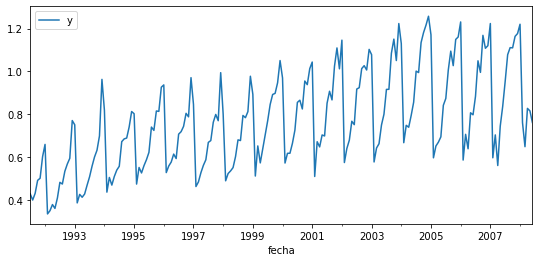

In [5]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
ax.legend();

In [6]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor=LinearRegression(),
                    lags=15
                )

forecaster.fit(y=datos_train)
forecaster

=======================ForecasterAutoreg=======================
Regressor: LinearRegression()
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Exogenous variable: False
Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}

Test error (mse): 0.011051937043503738


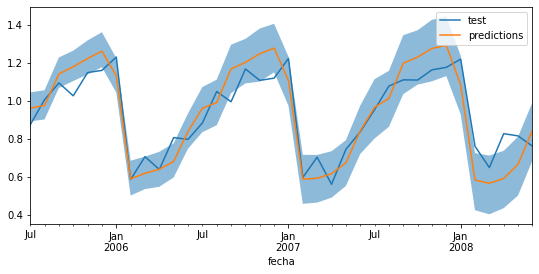

In [7]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [5, 95],
                    n_boot   = 1000, 
                    in_sample_residuals = True
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

In [8]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                        (datos_test >= predictions.iloc[:, 1]) \
                        & (datos_test <= predictions.iloc[:, 2]),
                        True,
                        False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {100 * cobertura}")

Cobertura del intervalo predicho: 72.22222222222221


[0.02150972]


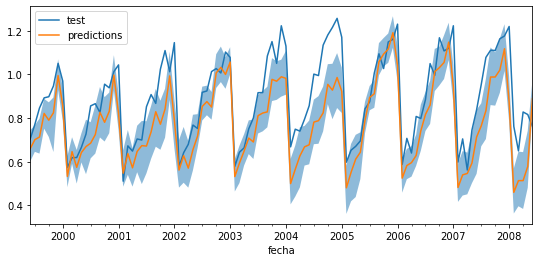

In [10]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

metrica, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'neg_mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True
                       )

print(metrica)

# Se añade el índice temporal a las predicciones
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

In [11]:
forecaster.fit(y=datos_train)
predictions_1 = forecaster.predict_interval(steps=steps)
print(len(predictions_1[:, 0]), predictions_1[:, 0])
print("")
predictions_2 = forecaster.predict_interval(steps=steps, last_window=datos_test[:steps])
print(len(predictions_2[:, 0]), predictions_2[:, 0])
print("")
predictions_3 = forecaster.predict_interval(steps=steps, last_window=datos_test[steps:steps*2])
print(len(predictions_3[:, 0]), predictions_3[:, 0])
print("")
predictions_4 = forecaster.predict_interval(steps=1, last_window=datos_test[steps*2:steps*3])
print(len(predictions_4[:, 0]), predictions_4[:, 0])
print("")
(predictions.iloc[:, 0] == np.concatenate([predictions_1[:, 0], predictions_2[:, 0], predictions_3[:, 0], predictions_4[:, 0]])).all()

36 [0.65975141 0.70083294 0.71322702 0.82118276 0.79016273 0.82429836
 0.99478547 0.85639271 0.53239718 0.64611528 0.57403328 0.64174981
 0.6692534  0.68494999 0.72421066 0.82635869 0.7805795  0.83090948
 0.99698484 0.82063913 0.54734782 0.63689091 0.57178966 0.64700865
 0.67365281 0.67169315 0.73657855 0.82921632 0.77173991 0.84127572
 0.99326797 0.79089549 0.56161618 0.62756698 0.57048122 0.65508333]

36 [0.7179964  0.85338817 0.8754706  0.85051013 1.00704991 1.03238786
 1.00018232 1.05684515 0.53179721 0.59370291 0.64874451 0.70818416
 0.69024412 0.81112373 0.82304019 0.82852027 0.97751844 0.96902967
 0.98929643 0.98206046 0.49958947 0.56489127 0.62663741 0.66805715
 0.67758601 0.78153956 0.78804939 0.82398326 0.95462158 0.92795873
 0.98601162 0.92275391 0.4802136  0.55092671 0.61167778 0.64344355]

36 [0.78955738 0.89431376 0.91162216 1.05840694 1.09347619 1.11631393
 1.19152211 1.04125414 0.52458912 0.58233782 0.59565852 0.62876208
 0.74089722 0.81648256 0.85960932 1.01275561 1.03

True

In [12]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                        (datos_test >= predictions.iloc[:, 1]) \
                        & (datos_test <= predictions.iloc[:, 2]),
                        True,
                        False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {100 * cobertura}")

Cobertura del intervalo predicho: 47.706422018348626


## Autoreg + 1 exogenous predictor
<br>

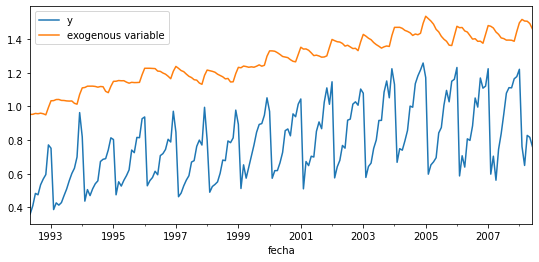

In [13]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variable
# ==============================================================================
datos_exog = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog = datos_exog[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog.plot(ax=ax, label='exogenous variable')
ax.legend();


# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog_train = datos_exog[:-steps]
datos_exog_test  = datos_exog[-steps:]

Test error (mse): 0.020306077140235405


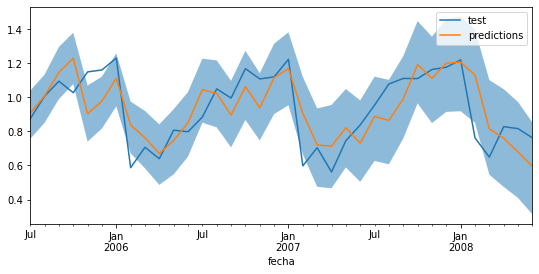

In [14]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

In [15]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metrica, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'neg_mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True
                       )

print(metrica)

[0.01325921]


## Autoregressive + n exogenous predictors
<br>

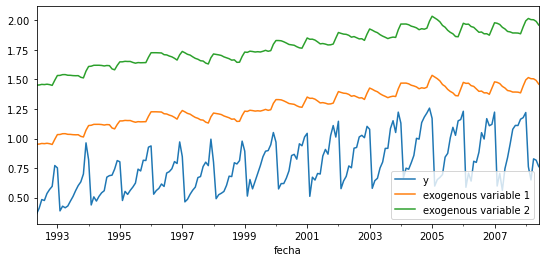

In [16]:
# Download data
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/h2o.csv'
datos = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

# Exogenous variables
# ==============================================================================
datos_exog_1 = datos.rolling(window=10, closed='right').mean() + 0.5
datos_exog_2 = datos.rolling(window=10, closed='right').mean() + 1
datos_exog_1 = datos_exog_1[10:]
datos_exog_2 = datos_exog_2[10:]
datos = datos[10:]

fig, ax=plt.subplots(figsize=(9, 4))
datos.plot(ax=ax, label='y')
datos_exog_1.plot(ax=ax, label='exogenous variable 1')
datos_exog_2.plot(ax=ax, label='exogenous variable 2')
ax.legend();

# Split train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

datos_exog = np.column_stack((datos_exog_1.values, datos_exog_2.values))
datos_exog_train = datos_exog[:-steps,]
datos_exog_test  = datos_exog[-steps:,]

Test error (mse): 0.02030607714023512


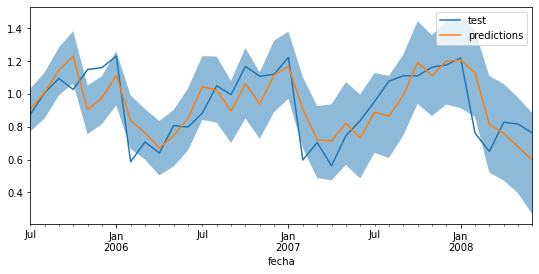

In [17]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags      = 8
             )

forecaster.fit(y=datos_train, exog=datos_exog_train)

# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    exog     = datos_exog_test,
                    interval = [5, 95],
                    n_boot   = 500
              )

# Add datetime index to predictions
predictions = pd.DataFrame(data=predictions, index=datos_test.index)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predictions.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(predictions.index,
                predictions.iloc[:, 1],
                predictions.iloc[:, 2],
                alpha=0.5)
ax.legend();

In [18]:
# Backtest with prediction intervals
# ==============================================================================
n_test = 36*3 + 1
datos_train = datos[:-n_test]
datos_test  = datos[-n_test:]
datos_exog_train = datos_exog[:-n_test]
datos_exog_test  = datos_exog[-n_test:]

steps = 36
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=8)

metrica, predictions = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos,
                            exog       = datos_exog,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            metric     = 'neg_mean_squared_error',
                            interval            = [5, 95],
                            n_boot              = 100,
                            in_sample_residuals = True
                       )

print(metrica)

[0.01325921]


## Intervalos estimados con residuos out-of-sample

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


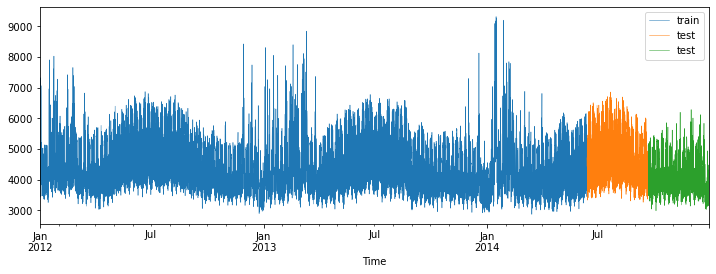

In [19]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/vic_elec.csv'
datos = pd.read_csv(url, sep=',')
datos.info()

# Conversión del formato fecha
# ==============================================================================
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()

# Agregado en intervalos de 1H
# ==============================================================================
# Se elimina la columna Date para que no genere error al agregar. La columna Holiday
# no genera error ya que es booleana y se trata como 0-1.
datos = datos.drop(columns='Date')
datos = datos.resample(rule='H', closed='left', label ='right').mean()
datos

# Separación datos train-validation-test
# ==============================================================================
dias_test = 100
dias_validacion = 100
datos = datos.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
fecha_fin_train   = datos.index[-1] - pd.Timedelta(dias_validacion + dias_test, unit='D')
fecha_inicio_validacion = fecha_fin_train + pd.Timedelta(1, unit='H')
fecha_fin_validacion    = fecha_inicio_validacion + pd.Timedelta(dias_validacion, unit='D')
fecha_inicio_test = fecha_fin_validacion + pd.Timedelta(1, unit='H')

datos_train       = datos.loc[: fecha_fin_train, :]
datos_validacion  = datos.loc[fecha_inicio_validacion:fecha_fin_validacion, :]
datos_test        = datos.loc[fecha_inicio_test:, :]

# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.Demand.plot(ax=ax, label='train', linewidth=0.5)
datos_validacion.Demand.plot(ax=ax, label='test', linewidth=0.5)
datos_test.Demand.plot(ax=ax, label='test', linewidth=0.5)
ax.legend();

In [20]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = Ridge(normalize=True),
                lags      = 24
             )

forecaster.fit(y=datos_train.Demand)
forecaster

=======================ForecasterAutoreg=======================
Regressor: Ridge(normalize=True)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Exogenous variable: False
Parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': True, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

In [21]:
# Backtest conjunto validación
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.Demand.loc[:fecha_fin_validacion],
                            initial_train_size = len(datos_train.Demand),
                            steps      = 24,
                            metric     = 'neg_mean_absolute_error'
                        )

Se calculan los errores de validación para utilizarlos como *out-sample-residuals* en la estimación de intervalos de predicción.

In [22]:
forecaster.out_sample_residuals = datos_validacion.Demand - predicciones

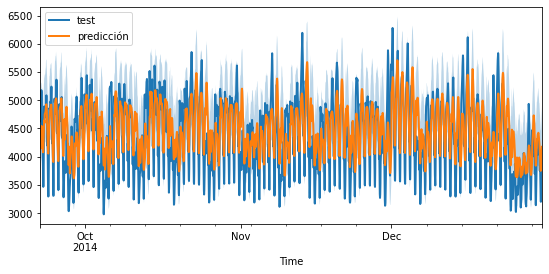

In [23]:
# Backtest con intervalos de predicción para el conjunto de test
# ==============================================================================
metrica, predicciones = backtesting_forecaster_intervals(
                            forecaster = forecaster,
                            y          = datos.Demand,
                            initial_train_size = len(datos_train.Demand) + len(datos_validacion.Demand),
                            steps      = 24,
                            metric     = 'neg_mean_absolute_error',
                            interval            = [5, 95],
                            n_boot              = 1000,
                            in_sample_residuals = False
                        )

# Se añade el índice temporal a las predicciones
predicciones = pd.DataFrame(data=predicciones, index=datos_test.index)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#datos_train.plot(ax=ax, label='train')
datos_test.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth=2, label='test')
predicciones.iloc[:, 0].plot(linewidth=2, label='predicción', ax=ax)
ax.fill_between(predicciones.index,
                predicciones.iloc[:, 1],
                predicciones.iloc[:, 2],
                alpha=0.3)
ax.legend();

In [24]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                        (datos_test.Demand >= predicciones.iloc[:, 1]) \
                        & (datos_test.Demand <= predicciones.iloc[:, 2]),
                        True,
                        False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {100 * cobertura}")

Cobertura del intervalo predicho: 80.03334722801168


El intervalo no consigue la cobertura esperada del 90%

## Información de sesión

In [25]:
from sinfo import sinfo
sinfo()

-----
matplotlib  3.3.2
numpy       1.19.5
pandas      1.2.3
sinfo       0.3.1
skforecast  0.1.7
sklearn     0.24.1
tqdm        4.59.0
-----
IPython             7.20.0
jupyter_client      6.1.11
jupyter_core        4.7.1
notebook            6.2.0
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.4.0-1041-aws-x86_64-with-debian-buster-sid
2 logical CPU cores, x86_64
-----
Session information updated at 2021-03-30 15:12
